In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

tf.random.set_seed(0)

In [2]:
# Feature lists
features = ["mean_order_book_imbalance", "num_traded_orders", 'mean_spread', 'std_spread', 'order_book_imbalance_5s',
            "mid_price_variation", "mean_mid_price", "std_mid_price"
]

In [3]:
sampling_rate = "1s"
prediction_column = "mid_price_variation_class"
batch_size = 32
look_back = 16

mid_price_variation_class_threshold = 0.0

In [4]:
from tf_preprocessing import process_and_combine_data

start_date = "2024-10-01"
end_date = "2024-10-01"

all_data = process_and_combine_data(start_date, end_date, mid_price_variation_class_threshold, data_folder="../AAPL_data", sampling_rate=sampling_rate)

print(all_data.columns)

all_data.head()

Index(['mid_price_first', 'mid_price_last', 'mid_price_high', 'mid_price_low',
       'mean_mid_price', 'std_mid_price', 'last_spread', 'mean_spread',
       'std_spread', 'best_bid_price', 'mean_best_bid_price',
       'std_best_bid_price', 'best_ask_price', 'mean_best_ask_price',
       'std_best_ask_price', 'best_bid_size', 'mean_best_bid_size',
       'std_best_bid_size', 'best_ask_size', 'mean_best_ask_size',
       'std_best_ask_size', 'mean_second_bid_ask_spread',
       'mean_second_bid_price', 'mid_price_variation',
       'mid_price_variation_class', 'total_bid_volume', 'total_ask_volume',
       'mean_order_book_imbalance', 'mean_volume_ratio_bid_ask',
       'total_net_order_flow', 'num_added_orders', 'num_canceled_orders',
       'num_traded_orders', 'order_book_imbalance_5s', 'volume_ratio_5s',
       'order_flow_5s', 'trade_open', 'trade_close', 'trade_high', 'trade_low',
       'dP_ask_dt', 'dP_bid_dt', 'dV_ask_dt', 'dV_bid_dt', 'ADX_5', 'ADX_7',
       'ADX_10', 'DMP_5

,mid_price_first,mid_price_last,mid_price_high,mid_price_low,mean_mid_price,std_mid_price,last_spread,mean_spread,std_spread,best_bid_price,...,MA20dSTD,CO,C1O1,C2O2,C3O3,range,OH1,time_since_open,is_monday,is_friday
ts_recv,,,,,,,,,,,,,,,,,,,,,
2024-10-01 09:30:51-04:00,228.610,228.585,228.615,228.585,228.601012,0.009403,0.03,0.040119,0.014767,228.57,...,0.117451,-0.025,-0.045,-0.060,0.075,0.030,0.000,51.0,0,0
2024-10-01 09:30:52-04:00,228.585,228.480,228.585,228.480,228.519567,0.031271,0.02,0.043426,0.010624,228.47,...,0.134609,-0.105,-0.025,-0.045,-0.060,0.105,0.005,52.0,0,0
2024-10-01 09:30:53-04:00,228.480,228.540,228.545,228.440,228.483996,0.036348,0.04,0.044779,0.014593,228.52,...,0.141017,0.060,-0.105,-0.025,-0.045,0.105,0.000,53.0,0,0
2024-10-01 09:30:54-04:00,228.540,228.570,228.625,228.540,228.587733,0.022043,0.04,0.041943,0.009342,228.55,...,0.141033,0.030,0.060,-0.105,-0.025,0.085,0.065,54.0,0,0
2024-10-01 09:30:55-04:00,228.570,228.665,228.710,228.570,228.637191,0.034168,0.05,0.041697,0.012570,228.64,...,0.139438,0.095,0.030,0.060,-0.105,0.140,0.085,55.0,0,0


In [5]:
all_data.mid_price_variation_class.value_counts()

mid_price_variation_class
 1.0    7057
-1.0    7007
 0.0    2581
Name: count, dtype: int64

In [10]:
all_data.dP_ask_dt

ts_recv
2024-10-01 09:30:51-04:00   -inf
2024-10-01 09:30:52-04:00    inf
2024-10-01 09:30:53-04:00    inf
2024-10-01 09:30:54-04:00    inf
2024-10-01 09:30:55-04:00    inf
                            ... 
2024-10-01 15:59:50-04:00    inf
2024-10-01 15:59:53-04:00    inf
2024-10-01 15:59:55-04:00    inf
2024-10-01 15:59:57-04:00    inf
2024-10-01 15:59:58-04:00    inf
Name: dP_ask_dt, Length: 16645, dtype: float64

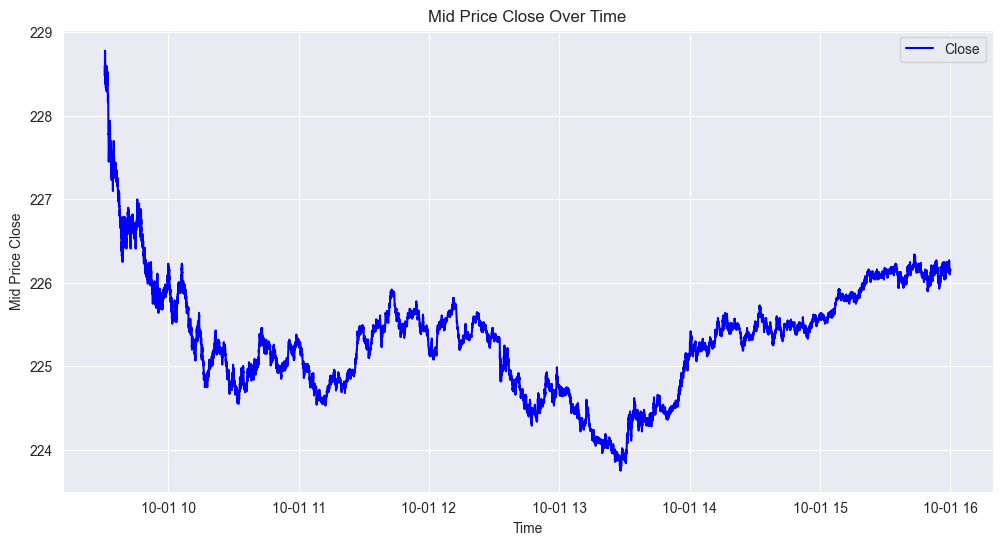

In [6]:
sns.set_style("darkgrid")

plt.figure(figsize=(12, 6))
plt.plot(all_data.index, all_data["trade_close"], label="Close", color="blue")
plt.xlabel("Time")
plt.ylabel("Mid Price Close")
plt.title("Mid Price Close Over Time")
plt.legend()
plt.show()

In [7]:
# Data Splitting
train_size = int(len(all_data) * 0.7)
val_size = int(len(all_data) * 0.1)
test_size = len(all_data) - train_size - val_size

train_df = all_data.iloc[:train_size, :]
val_df = all_data.iloc[train_size:train_size + val_size, :]
test_df = all_data.iloc[train_size + val_size:, :]

In [8]:
from time_series_generators import TimeSeriesGenerator, TimeSeriesScalerGenerator
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Fit scalers on training data only
minmax_scaler = MinMaxScaler(feature_range=(0, 1)).fit(train_df[features])

# Apply scalers to training, validation, and test sets
train_scaled = minmax_scaler.transform(train_df[features])
val_scaled = minmax_scaler.transform(val_df[features])
test_scaled = minmax_scaler.transform(test_df[features])

# Extract targets separately
train_target = train_df[prediction_column].values
val_target = val_df[prediction_column].values
test_target = test_df[prediction_column].values

# Create generators with pre-scaled data
train_gen = TimeSeriesGenerator(train_scaled, train_target, look_back=look_back, batch_size=batch_size)
val_gen = TimeSeriesGenerator(val_scaled, val_target, look_back=look_back, batch_size=batch_size)
test_gen = TimeSeriesGenerator(test_scaled, test_target, look_back=look_back, batch_size=batch_size)

In [9]:
from keras import layers, models, optimizers

def create_model():
    input_size = len(features)
    inputs = layers.Input(shape=(look_back, input_size))

    # First LSTM layer
    x = layers.LSTM(128, return_sequences=True)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)

    # Second LSTM layer
    x = layers.LSTM(64, return_sequences=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)

    # Dense layers
    x = layers.Dense(32, activation="relu")(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(3, activation="softmax")(x)

    # Create model
    model = models.Model(inputs=inputs, outputs=outputs)
    return model

num_models = 1
epochs = 5
all_predictions = []

for i in range(num_models):
    print(f"Training model {i + 1}/{num_models}")
    tf.random.set_seed(i + 1)
    model = create_model()
    # optimizer = optimizers.Adam(learning_rate=0.001)
    optimizer = optimizers.SGD(learning_rate=0.001, momentum=0.9)
    model.compile(optimizer=optimizer, 
                  loss="sparse_categorical_crossentropy", 
                  metrics=["accuracy"])
    
    model.fit(train_gen, validation_data=val_gen, epochs=epochs)
    
    predictions = model.predict(test_gen)
    all_predictions.append(predictions)


Training model 1/1
Epoch 1/5


InvalidArgumentError: Graph execution error:

Detected at node compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Laurent Liao\AppData\Roaming\Python\Python312\site-packages\ipykernel_launcher.py", line 18, in <module>

  File "C:\Users\Laurent Liao\AppData\Roaming\Python\Python312\site-packages\traitlets\config\application.py", line 1075, in launch_instance

  File "C:\Users\Laurent Liao\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelapp.py", line 739, in start

  File "C:\Users\Laurent Liao\AppData\Roaming\Python\Python312\site-packages\tornado\platform\asyncio.py", line 205, in start

  File "c:\Users\Laurent Liao\AppData\Local\Programs\Python\Python312\Lib\asyncio\base_events.py", line 641, in run_forever

  File "c:\Users\Laurent Liao\AppData\Local\Programs\Python\Python312\Lib\asyncio\base_events.py", line 1987, in _run_once

  File "c:\Users\Laurent Liao\AppData\Local\Programs\Python\Python312\Lib\asyncio\events.py", line 88, in _run

  File "C:\Users\Laurent Liao\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue

  File "C:\Users\Laurent Liao\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelbase.py", line 534, in process_one

  File "C:\Users\Laurent Liao\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell

  File "C:\Users\Laurent Liao\AppData\Roaming\Python\Python312\site-packages\ipykernel\ipkernel.py", line 362, in execute_request

  File "C:\Users\Laurent Liao\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelbase.py", line 778, in execute_request

  File "C:\Users\Laurent Liao\AppData\Roaming\Python\Python312\site-packages\ipykernel\ipkernel.py", line 449, in do_execute

  File "C:\Users\Laurent Liao\AppData\Roaming\Python\Python312\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "C:\Users\Laurent Liao\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell

  File "C:\Users\Laurent Liao\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell

  File "C:\Users\Laurent Liao\AppData\Roaming\Python\Python312\site-packages\IPython\core\async_helpers.py", line 128, in _pseudo_sync_runner

  File "C:\Users\Laurent Liao\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async

  File "C:\Users\Laurent Liao\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes

  File "C:\Users\Laurent Liao\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code

  File "C:\Users\Laurent Liao\AppData\Local\Temp\ipykernel_19720\4109835582.py", line 40, in <module>

  File "c:\Users\Laurent Liao\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\Laurent Liao\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 320, in fit

  File "c:\Users\Laurent Liao\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 121, in one_step_on_iterator

  File "c:\Users\Laurent Liao\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 108, in one_step_on_data

  File "c:\Users\Laurent Liao\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 54, in train_step

  File "c:\Users\Laurent Liao\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\trainer.py", line 398, in _compute_loss

  File "c:\Users\Laurent Liao\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\trainer.py", line 366, in compute_loss

  File "c:\Users\Laurent Liao\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\compile_utils.py", line 618, in __call__

  File "c:\Users\Laurent Liao\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\compile_utils.py", line 659, in call

  File "c:\Users\Laurent Liao\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\losses\loss.py", line 60, in __call__

  File "c:\Users\Laurent Liao\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\losses\losses.py", line 27, in call

  File "c:\Users\Laurent Liao\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\losses\losses.py", line 1870, in sparse_categorical_crossentropy

  File "c:\Users\Laurent Liao\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py", line 1559, in sparse_categorical_crossentropy

  File "c:\Users\Laurent Liao\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\nn.py", line 671, in sparse_categorical_crossentropy

Received a label value of -1 which is outside the valid range of [0, 3).  Label values: 1 -1 0 -1 1 1 1 0 1 -1 -1 1 -1 1 -1 1 1 -1 -1 1 -1 -1 -1 1 -1 1 -1 1 -1 -1 1 -1
	 [[{{node compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_one_step_on_iterator_4021]

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

def plot_evaluation_metrics(y_true, y_pred, log_probabilities):
    probabilities = np.exp(log_probabilities)

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Confusion Matrix (updated for 3 classes)
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        ax=axes[0],
        xticklabels=["Down (0)", "Constant (1)", "Up (2)"],  # Updated class labels with meaning
        yticklabels=["Down (0)", "Constant (1)", "Up (2)"],  # Updated class labels with meaning
    )
    axes[0].set_title("Confusion Matrix")
    axes[0].set_xlabel("Predicted")
    axes[0].set_ylabel("True")

    # Histogram of Predicted Probabilities (updated for 3 classes)
    for i, class_label in enumerate(["Down (0)", "Constant (1)", "Up (2)"]):  # Updated class labels with meaning
        sns.histplot(
            probabilities[y_true == i][:, i], bins=30, label=class_label, ax=axes[1]
        )
    axes[1].set_title("Probability Distribution")
    axes[1].set_xlabel("Predicted Probability")
    axes[1].legend()

    # Scatter Plot of Predictions (updated for 3 classes)
    scatter = sns.scatterplot(
        x=np.arange(len(probabilities)),
        y=probabilities.max(axis=1),
        hue=y_true,
        palette={0: "red", 1: "blue", 2: "green"},  # Updated palette for 0, 1, 2
        alpha=0.7,
        ax=axes[2],
    )
    axes[2].set_title("Scatter Plot of Predictions")
    axes[2].set_xlabel("Sample Index")
    axes[2].set_ylabel("Max Predicted Probability")

    handles, labels = scatter.get_legend_handles_labels()
    new_labels = ["Down (0)", "Constant (1)", "Up (2)"]  # Updated class labels with meaning
    axes[2].legend(handles, new_labels, title="True Class")

    axes[2].tick_params(axis="x", rotation=45)

    plt.tight_layout()
    plt.show()

    # Print Evaluation Metrics
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(classification_report(y_true, y_pred, zero_division=0))

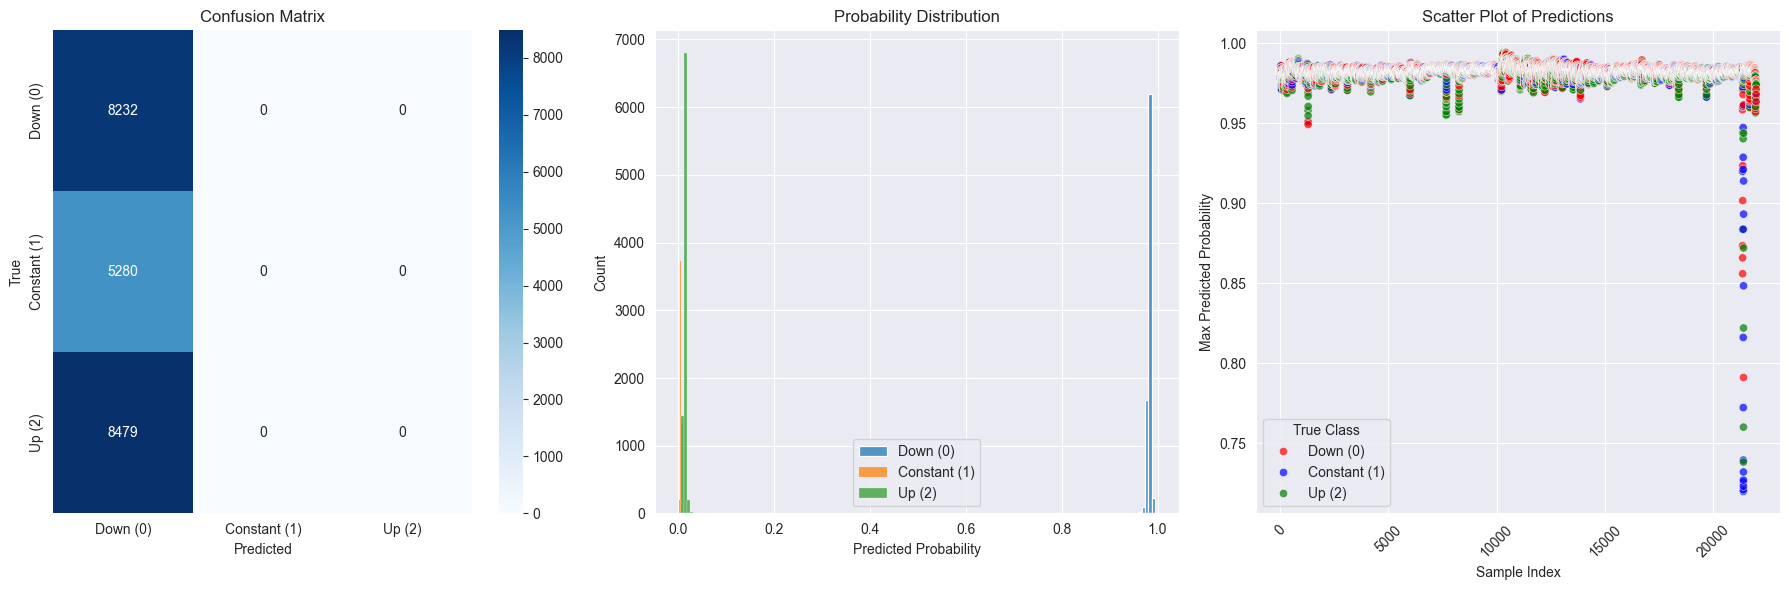

Accuracy: 0.3743
              precision    recall  f1-score   support

           0       0.37      1.00      0.54      8232
           1       0.00      0.00      0.00      5280
           2       0.00      0.00      0.00      8479

    accuracy                           0.37     21991
   macro avg       0.12      0.33      0.18     21991
weighted avg       0.14      0.37      0.20     21991



In [ ]:
# Convert predictions to class labels
all_predictions = np.array(all_predictions)
predicted_classes = np.argmax(all_predictions, axis=-1)

# Majority voting
final_predictions = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=predicted_classes)

# Compute log probabilities for evaluation
log_probabilities = np.log(np.mean(all_predictions, axis=0))

# Evaluate the final predictions
y_true = test_gen.true_labels  # Assuming test_gen has the true labels
plot_evaluation_metrics(y_true, final_predictions, log_probabilities)

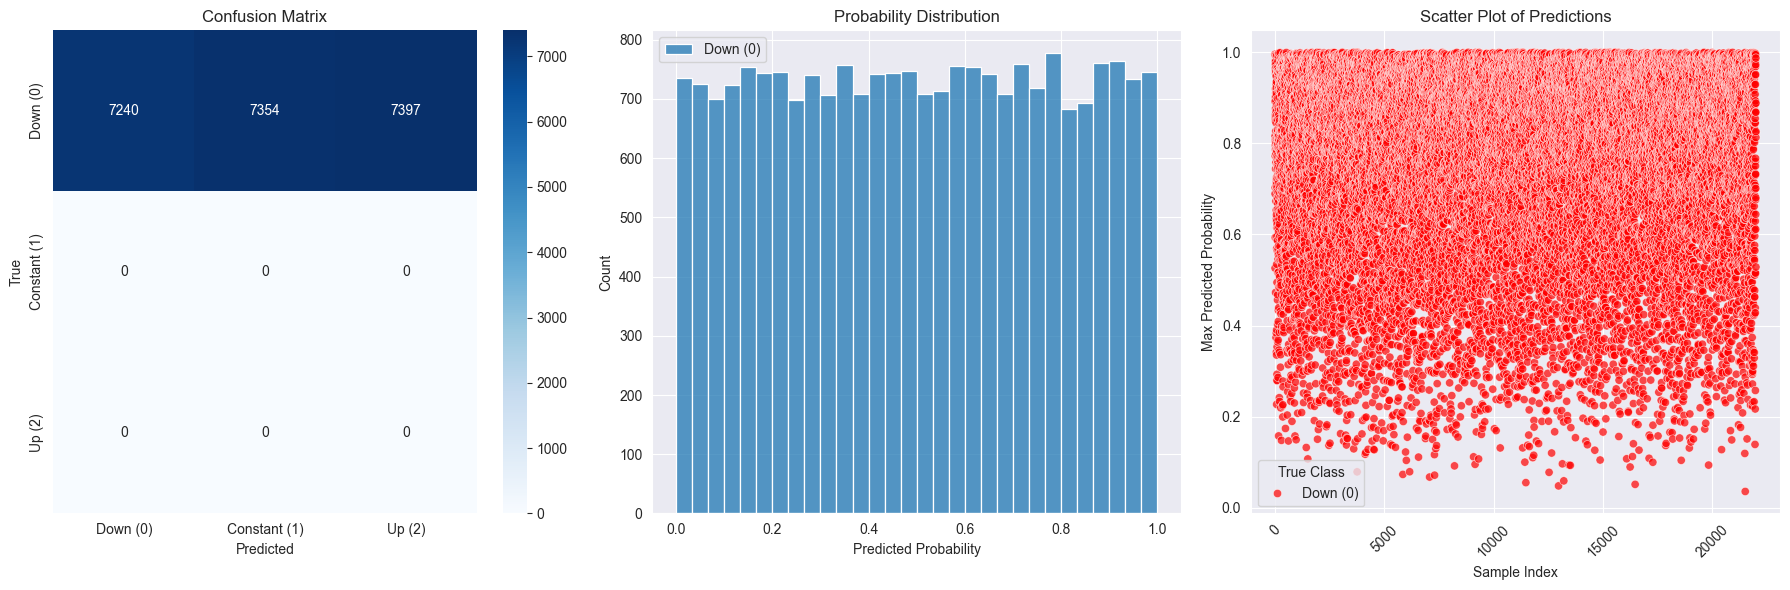

Accuracy: 0.3292
              precision    recall  f1-score   support

           0       1.00      0.33      0.50     21991
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0

    accuracy                           0.33     21991
   macro avg       0.33      0.11      0.17     21991
weighted avg       1.00      0.33      0.50     21991



In [ ]:
# Implement a random strategy
random_y_pred = np.random.randint(0, 3, size=len(final_predictions))
random_log_probabilities = np.log(np.random.rand(len(final_predictions), 3))

# Plot evaluation metrics for the random strategy
plot_evaluation_metrics(final_predictions, random_y_pred, random_log_probabilities)